# PIPELINE

After some experiments with classification algorithims it would be interesting to try clustering texts not from school websites. However I do not know how many clusters are needed so my plan looks like this:

- primitive frequency analysis of words + observation of Zipf's law
- finding the optimal number of clusters
- KMeans clusterization
- visualization of clusterized data

# Primitive frequency analysis of words

In [1]:
# pandas and numpy for manipulating with data
import pandas as pd
import numpy as np

# for data plots
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from wordcloud import WordCloud

# for checking progress of functions
from tqdm.auto import tqdm

# nltk statistics
from nltk.probability import FreqDist

# vectorization model
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('school_normalized.csv')

Preparing two different datasets for data manipualtions.

In [3]:
df_school = df[df['school'] == 1]
df = df[df['school'] == 0]

In [4]:
# extra data checking
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1843 entries, 5 to 3601
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1843 non-null   int64 
 1   main_page   1843 non-null   object
 2   school      1843 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 57.6+ KB


In [5]:
# extra data checking
df_school.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1761 entries, 0 to 3603
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1761 non-null   int64 
 1   main_page   1761 non-null   object
 2   school      1761 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.0+ KB


Some functions for data preparation in order to join into str or list all column's cells.

In [6]:
from functools import reduce

def join_str(column):
    return reduce(lambda s1, s2: s1 + s2, column, '')

def join_list(column):
    return reduce(lambda l1, l2: l1 + l2.split(), column, [])

I'm going to use **FreqDist** from **NLTK** which gives a huge dictionary of words and their frequency stats in the text + some convinient vizualization methods as atributes. In order to optimize the proccess and clean all useless lemmas (words) of 3 and less letters, I filter the list of cells *(FreqDist works with flatten list of all words)*. Also, I use copy in the algorithm because it empties my sequence *(as far as I understand)*. I show only top 50 words.

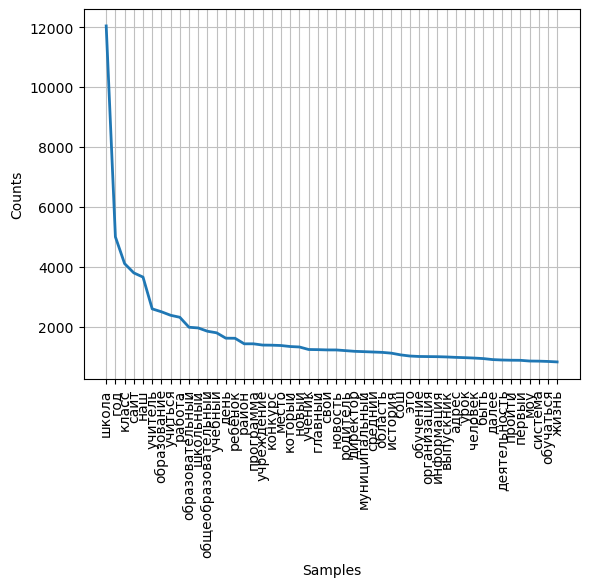

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [7]:
len_filtered_school = list(filter(lambda x: len(x) >= 3, join_list(df_school['main_page'])))
freq_school = FreqDist(len_filtered_school.copy())

freq_school.plot(50)

Moreover, I want to compare this data with vectorized words and the most influential lemmas sorted by TF-IDF values.

In [8]:
vector_model = TfidfVectorizer()
X_school = vector_model.fit_transform(df_school['main_page'])

In [9]:
X_school.shape

(1761, 30372)

In order to get a list of words sorted by TF-IDF values, I sum all vectors by axis=0 and ravel it after converting to **np.array** *(the sequence of actions is important because X_school is an object of SciPy sparsed-matrix wich doesn't have necessary methods)*. As a result, I have a one dimensional list of TF-IDF values which I sort by values *(and I return indexes of arguments by **np.argsort**)*. However, **np.argsort** can't sort in reverse order so I take a slice [::-1]. Then I get feature names out and filter it by indexes from previous step *(taking only top-50 words)*.

In [10]:
TF_IDF_values = np.array(X_school.sum(axis=0)).ravel()
TF_IDF_reversed = np.argsort(TF_IDF_values)[::-1]

names = vector_model.get_feature_names_out()
top_50_TF_IDF = np.array(names)[TF_IDF_reversed[:50]]

top_50_TF_IDF

array(['школа', 'сайт', 'наш', 'год', 'класс', 'общеобразовательный',
       'учитель', 'образование', 'работа', 'главный', 'школьный',
       'новость', 'образовательный', 'учиться', 'средний', 'район',
       'адрес', 'учреждение', 'учебный', 'муниципальный', 'история',
       'область', 'информация', 'ученик', 'новый', 'сош', 'директор',
       'моу', 'страница', 'система', 'программа', 'ребёнок', 'день',
       'родитель', 'гостевой', 'город', 'документ', 'выпускник', 'ул',
       'далее', 'обучение', 'конкурс', 'телефон', 'создать', 'книга',
       'это', 'который', 'деятельность', 'свой', 'добро'], dtype=object)

Interestingly, **Zipf's law** also works a bit on TF-IDF values.

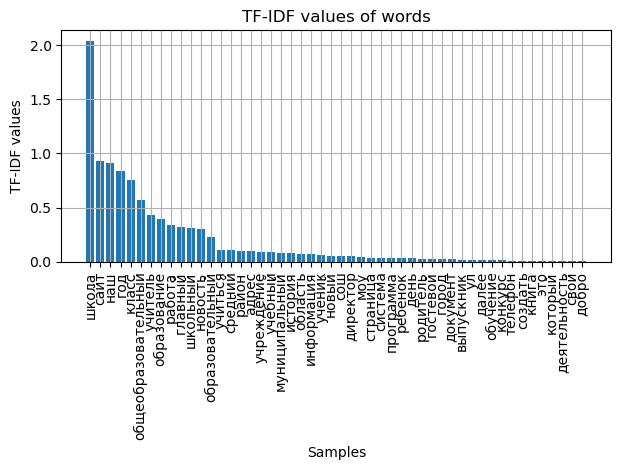

In [11]:
plt.bar(x=range(50), height=np.sort(TF_IDF_values[:50])[::-1], tick_label=top_50_TF_IDF)

plt.xlabel('Samples')
plt.ylabel('TF-IDF values')
plt.title('TF-IDF values of words')
plt.grid()
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

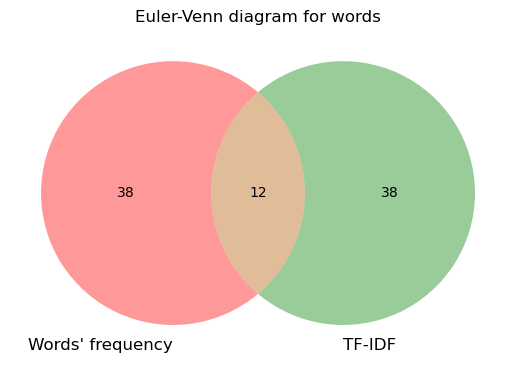

In [12]:
set1, set2 = set(list(freq_school.keys())[:50]), set(top_50_TF_IDF)

venn = venn2([set1, set2], set_labels=("Words' frequency", 'TF-IDF'))
plt.title("Euler-Venn diagram for words")

plt.show()

In [13]:
' '.join(set1 & set2)

'общеобразовательный главный образование моу сайт школа страница который работа родитель учиться учреждение'

Of the two different statistics, only 12 words match. Thus, despite the fact that some words may have a high frequency, they may be less significant in their influence than other words. The correlation between the frequency and significance of words is not direct. However there are can be some exceptions like the word 'школа' which has become an almost guaranteed indicator of the "school website" class.

Another standard and cliched visualization of frequently occurring words is **word clouds**:

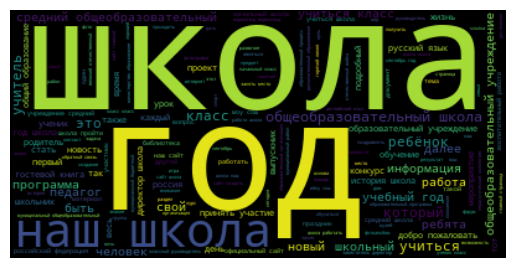

In [14]:
wordcloud = WordCloud().generate(' '.join(len_filtered_school))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Now I'll do the same thing with the second class *(but without comparison with TF-IDF values)* in order to try to estimate the approximate spread of topics of future clusters by frequency words.

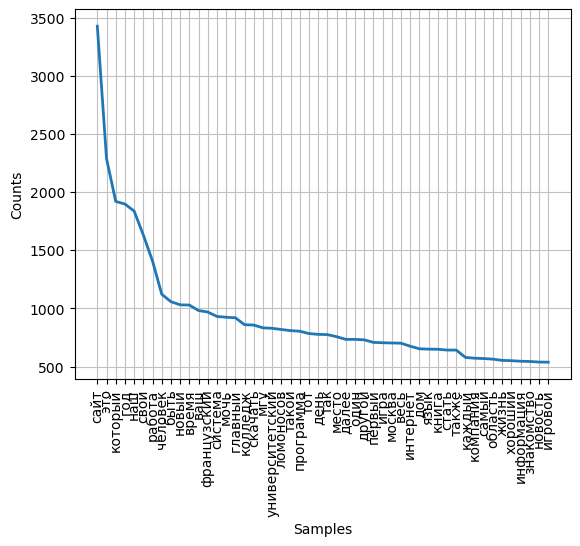

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [15]:
len_filtered = list(filter(lambda x: len(x) >= 3, join_list(df['main_page'])))
freq = FreqDist(len_filtered.copy())

freq.plot(50)

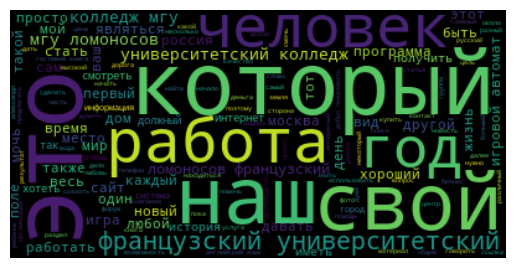

In [16]:
wordcloud = WordCloud().generate(' '.join(len_filtered))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Finding the optimal number of clusters

In [23]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

Firstly, I'm going to use **AgglomerativeClustering** as a hierarchical clustering algorithm in order to automatically find the optimal number of clusters + **TF-IDF** with 3n-gramms *(usually a view of the context gives more information)*. However, I've reduced **max_features** to 10_000 because it gives the same number of clusters as without limits *(some kind of optimisation)*.

The algorithm gradually merges the points into clusters. 

In [17]:
vector_model = TfidfVectorizer(ngram_range=(1,3), max_features=10_000)
X_train = vector_model.fit_transform(df['main_page'])

In [18]:
X_train.shape

(1843, 10000)

When using **distance_threshold=0**, the algorithm builds a complete hierarchical clustering tree that includes all possible clusters of individual points to a single cluster. This is called the "full" or "agglomerative" method of hierarchical clustering, but I decided not to specify the value so that the algorithm would pick up the optimal number of clusters itself.

In [29]:
AC = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
clusters = AC.fit_predict(X_train.toarray())
clusters

array([1469, 1407, 1691, ...,    6,    2,    0], dtype=int64)

In [30]:
len(clusters)

1843

It would also be nice to look at the **dendrogram** and evaluate the whole process of the hierarchical algorithm from the outside. The leaves correspond to individual data points, and the combined clusters are located higher up the tree. The vertical axis shows the measure of the distance between the combined clusters, and the horizontal axis shows the clusters themselves and the data points. 

It's necessary to built a **linkage matrix** with 'ward'. Also, it's important to give an array of data instead of ScyPy sparsed-matrix. Unfortunately, the number of clusters really seems to be 1843, which is a lot, given the initial amount of data in about 1843 rows :). With such a close number, it doesn't make much sense to divide the data into clusters, because each text will be a separate cluster.

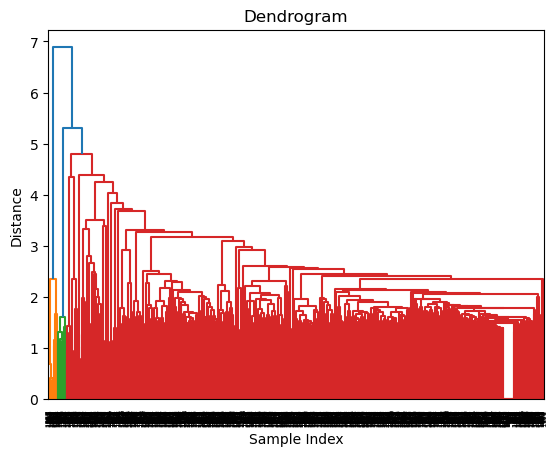

In [31]:
linkage_matrix = linkage(X_train.toarray(), method='ward')

dendrogram(linkage_matrix)
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.show()

In [32]:
linkage_matrix.shape

(1842, 4)

The **silhouette_score** is a metric that helps to evaluate the quality of clustering without using true class labels (without a teacher). It allows you to determine how much objects within one cluster are more similar to each other than objects from other clusters. The higher the value of **silhouette_score**, the better the clustering quality. Using this metric, you can once again make sure that with each iteration of increasing the number of clusters the quality only grows.

I once again modeled the previous situation only with the metric estimate. Each iteration increased the number of steps by 10 to speed up the algorithm.


In [33]:
silhouette_scores = []
stop_value = 1840
for i_clusters in tqdm(range(2, stop_value, 10)):
    clustering = AgglomerativeClustering(n_clusters=i_clusters)
    labels = clustering.fit_predict(X_train.toarray())
    silhouette_scores.append(silhouette_score(X_train.toarray(), labels))

  0%|          | 0/184 [00:00<?, ?it/s]

Building a graph of changes in metric values. 

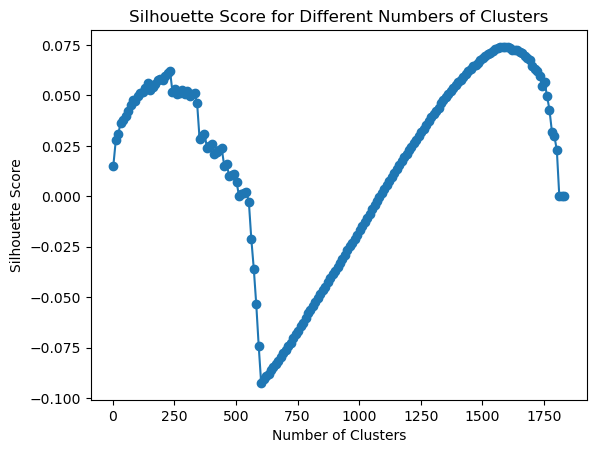

In [37]:
plt.plot(range(2, stop_value, 10), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()

# Clusterization

In general, the optimal number of clusters is about 250 or 1500. Considering that the creation of 1500 clusters is not suitable for optimization and in theory *(because there are only 1800 data observations)*, it probably makes sense to take **250 clusters**. For visualization, this will be a bit of a difficult task, so I will try to simplify it by working only with, for example, 25 clusters ***(although the number 250 as an answer to the clustering problem suits me)***

This time I'm using more standard and well-known clustering methods like KMeans

In [19]:
from sklearn.cluster import KMeans

In [20]:
n_clusters = 25
km = KMeans(n_clusters=n_clusters)
km.fit(X_train)

KMeans(n_clusters=25)

In [21]:
clusters = km.labels_.tolist()

# making a copy just in case
d = df.copy()
d['KMeans'] = clusters

In [22]:
d

,Unnamed: 0,main_page,school,KMeans
5,6,женский одежда больший размер главный страниц...,0,2
6,7,ричард бричард народ ру официальный сайт кото...,0,19
7,8,о семья фотоальбом путешествие всякий другой ...,0,11
9,10,сдать квартира одесса долгосрочно пос лок кот...,0,13
10,11,сборка мебель москва главный наш специалист и...,0,7
...,...,...,...,...
3594,3620,первый русский сервер адрес сайт сервер беспл...,0,20
3596,3622,проект открытый проект информационно культурн...,0,7
3598,3624,антон иванов анна устинов здаров нравиться ан...,0,11
3599,3625,главный книга сделать бесплатный сайт,0,3


# Visualization

Here I will simply try to visualize the space of the resulting clusters. To begin with, I will make word clouds for each cluster:

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(n_clusters):
    plt.subplot(5, 5, i+1)  # grid of 5 rows and 5 columns
    wordcloud = WordCloud().generate(join_str(d[d['KMeans'] == i]['main_page']))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud {i+1}')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

To visualize a 10_000-dimensional space, you need to reduce the dimension of the vector matrix to at least 3. I'll use standart **IncrementalPCA** method because it's is more optimized than **PCA**.

First, I'll build a matrix of the **cosine distance** of all vectors, on the basis of which the dimension reduction will occur. We will subtract all values from 1 to bring them to a common range of [0; 2] instead of [-1: 1].

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

In [44]:
dist = 1 - cosine_similarity(X_train)
dist.shape

(1843, 1843)

Now, based on the **distance matrix**, I can get a new coordinate for each of the axes in 3-dimensional space. Although of course it is worth considering that when the dimension is lowered, some of the necessary information is lost and only an approximate picture is obtained.

In [45]:
from sklearn.decomposition import IncrementalPCA

In [46]:
icpa = IncrementalPCA(n_components=3, batch_size=16)
new_X = icpa.fit_transform(dist)
x, y, z = new_X[:, 0], new_X[:, 1], new_X[:, 2]

### The primary pattern of the scattering plot

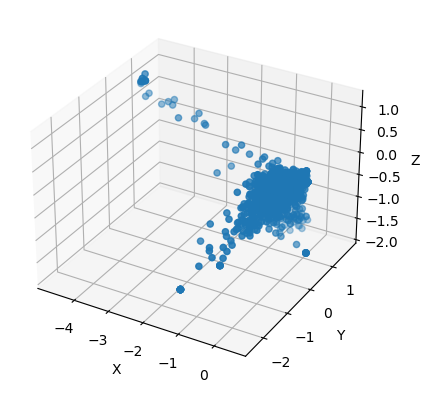

In [47]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

### The scattering plot v.2

This time let's color all the points according to the classes.

For the function of generating colors and in general tips in visualizing the clustering task, thanks to this article on habra: https://habr.com/ru/articles/346206/

In [48]:
import random
def generate_colors(n):
    color_list = []
    for c in range(0, n):
        r = lambda: random.randint(0,255)
        color_list.append( '#%02X%02X%02X' % (r(),r(),r()) )
    return color_list

In [52]:
cluster_colors = dict(zip(range(n_clusters), generate_colors(25)))
cluster_names = {i: str(i) for i in range(n_clusters)}

In [53]:
df_new = pd.DataFrame(dict(x=x, y=y, z=z, label=clusters, title=df['main_page']))
groups = df_new.groupby('label')

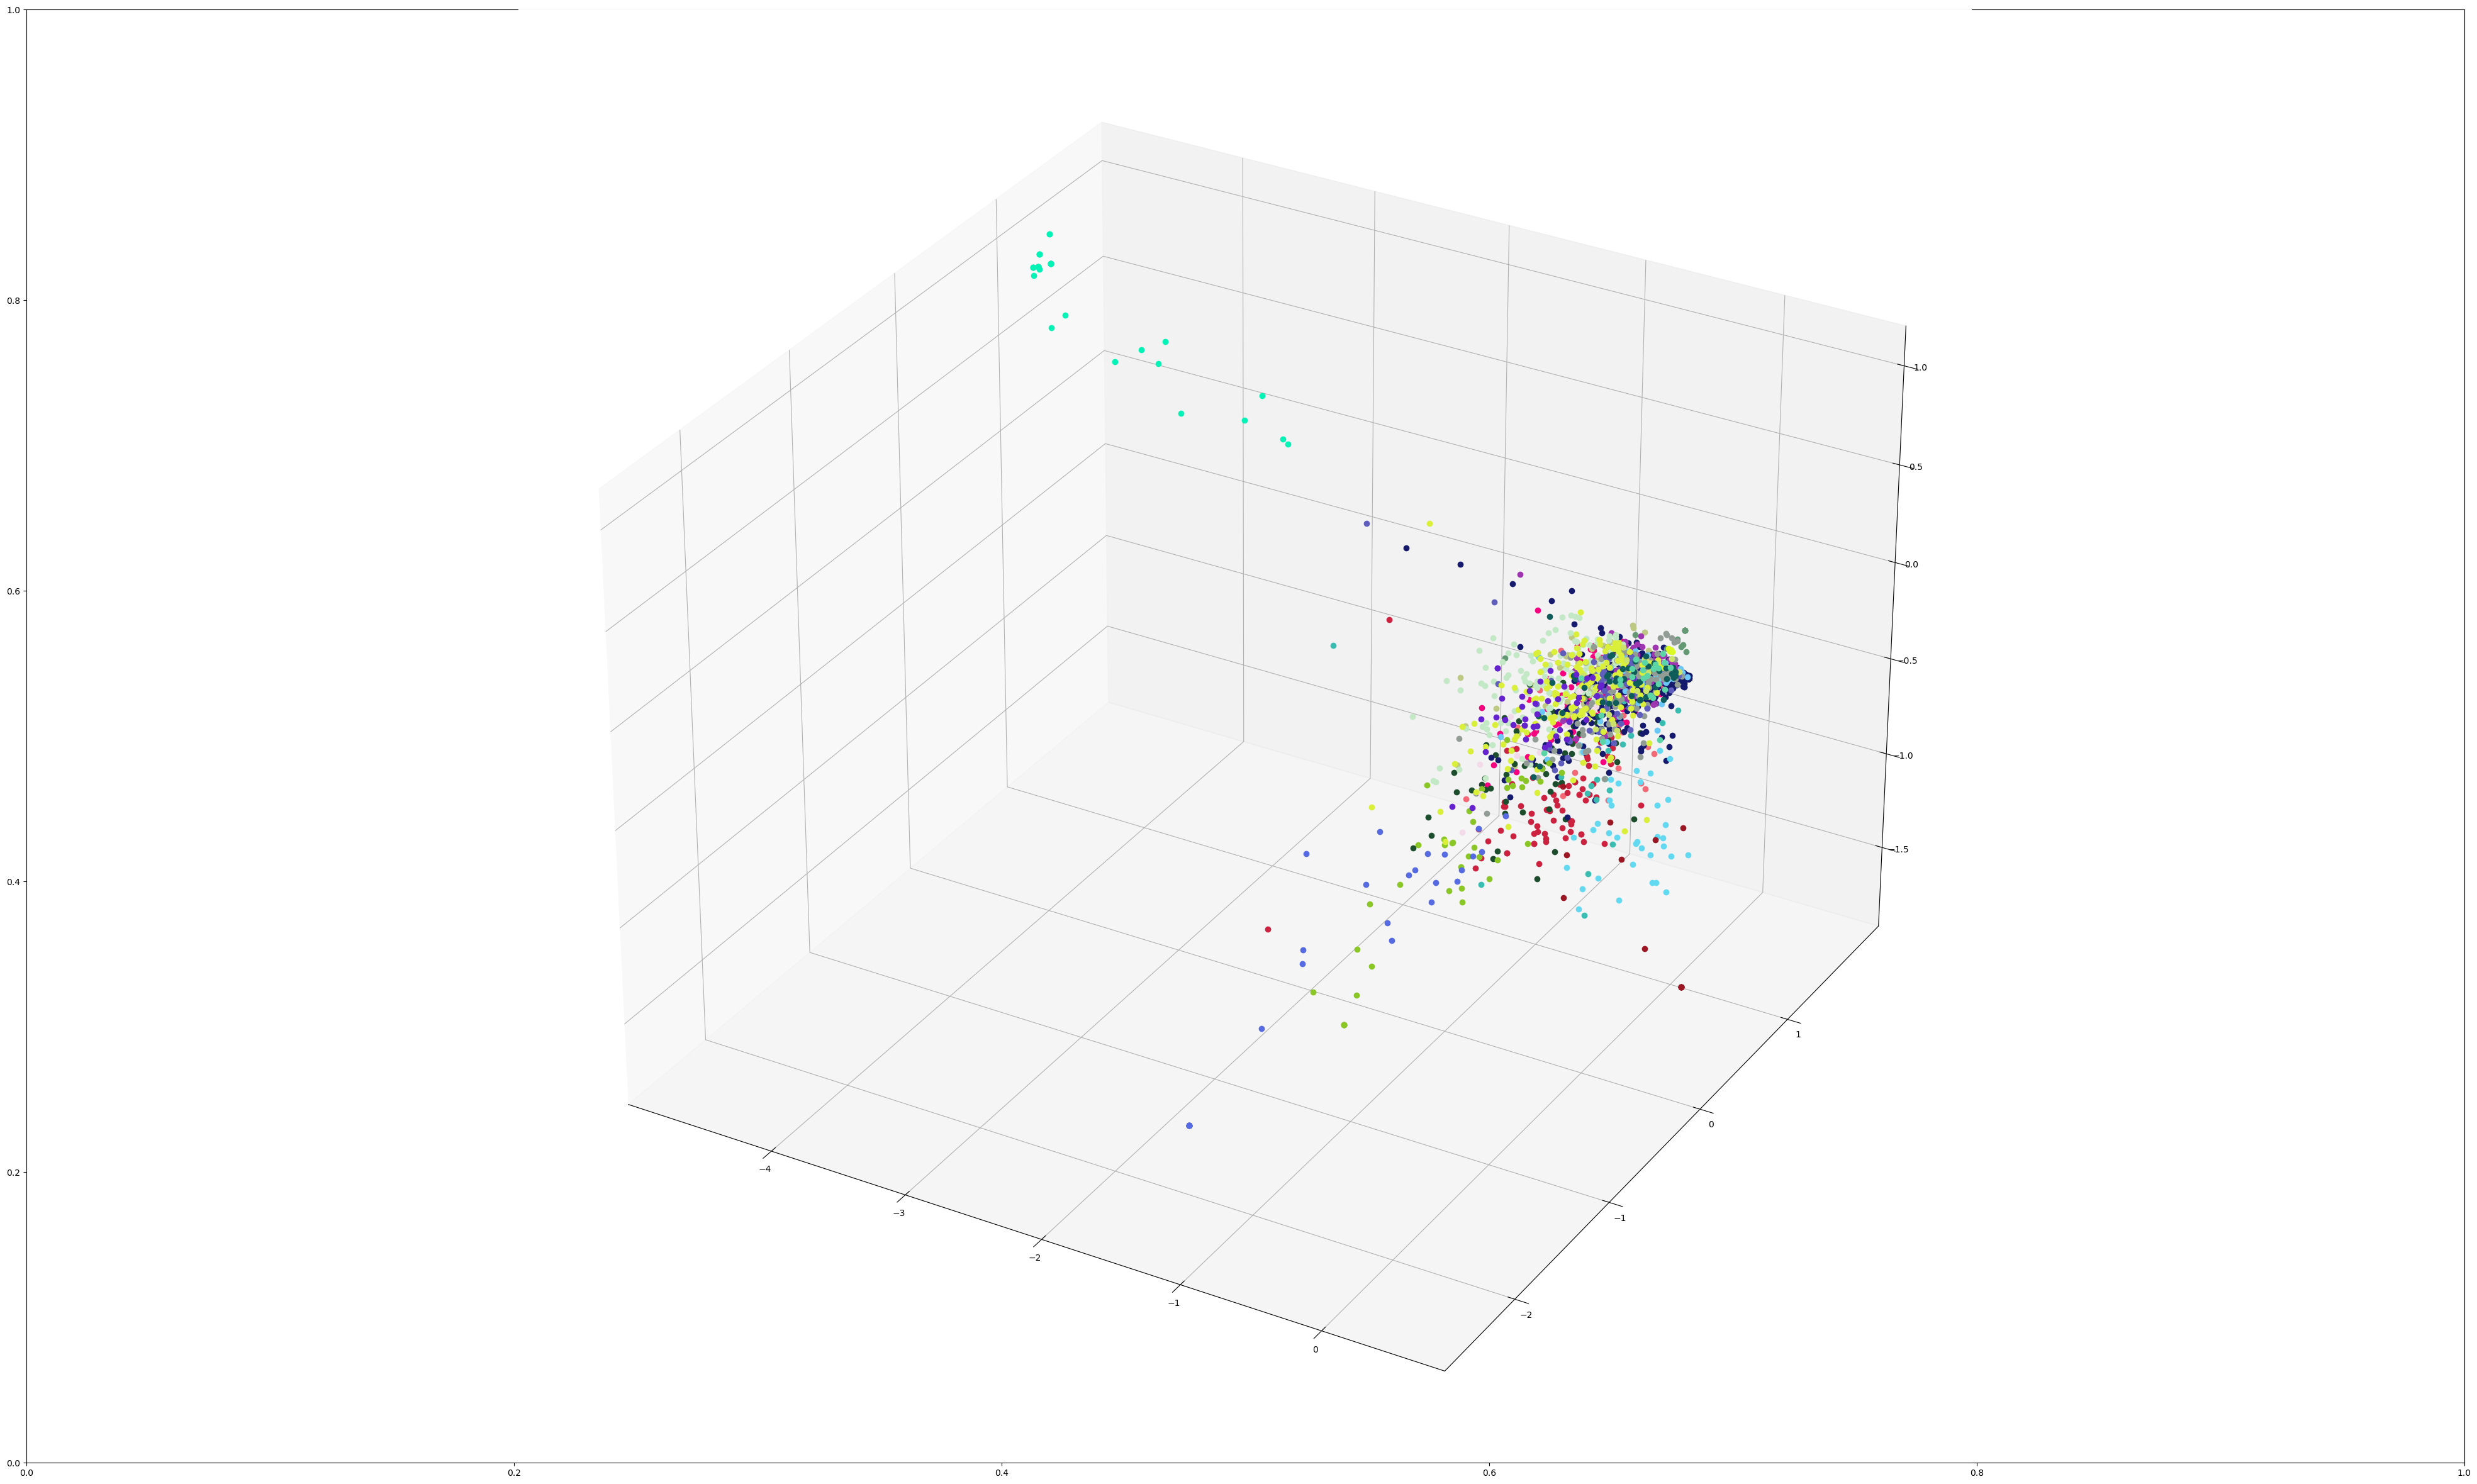

In [54]:
fig, ax = plt.subplots(figsize=(50, 30))
ax = fig.add_subplot(projection='3d')

for name, group in groups:
    ax.plot(group.x, group.y, group.z, marker='o', linestyle='', label=cluster_names[name], color=cluster_colors[name])

plt.show() 

### The scattering plot v.3 - interactive

In [ ]:
import plotly.express as px

fig = px.scatter_3d(df_new, x='x', y='y', z='z',
              color='label', size_max=5, hover_name='title')

The statterplot will be saved as html-file.

In [59]:
fig.write_html("clusterization_plot.html")